https://www.kaggle.com/datasets/nathanaeltenno/protel-dataset

In [1]:
import torch
import torchvision
import json

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

print(torch.__version__)
print(torchvision.__version__)

2.3.0.dev20240120+cu121
0.18.0.dev20240120+cu121


In [2]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import glob
import numpy as np

from sklearn.model_selection import train_test_split
from pathlib import Path

In [3]:
# clear cuda
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# config
SEED = 42
BATCH_SIZE = 24
EPOCHS = 20

In [5]:
### import custom scripts
from scripts import engine_classification, custom_dataset, create_data_splits

In [6]:
# root path
root_path = Path(os.getcwd())
print(root_path)

# directories
train_dir = root_path / "dataset_subset" / "train"
val_dir = root_path / "dataset_subset" / "val"
test_dir = root_path / "dataset_subset" / "test"

/mnt/DiscoD/00_Learning/00_ArtificialIntelligence/AI_Aplications/10_Fruits_protel


In [7]:
classes_ = os.listdir(root_path / "dataset")
len(classes_)

30

In [8]:
# Filter for FRESH category
classes = list(filter(lambda x: "Fresh" in x, classes_)) 
print(len(classes))
print(classes)

15
['FreshAlpukat', 'FreshApple', 'FreshBanana', 'FreshBellpepper', 'FreshCabbage', 'FreshCarrot', 'FreshCucumber', 'FreshDragonfruit', 'FreshMango', 'FreshOrange', 'FreshPapaya', 'FreshPotato', 'FreshSpinach', 'FreshStrawberry', 'FreshTomato']


### Create splits dir

In [10]:
# create
train_ratio=0.6
val_ratio=0.2
test_ratio=0.1

create_data_splits.create_data_splits(root_path / "dataset", classes, train_dir, test_dir, val_dir, train_ratio, test_ratio, val_ratio, SEED)

### Setup model

In [11]:
# Initialize model with the best available weights
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [12]:
# Freeze / (or not) all of the base layers in model
for param in model.parameters():
  param.requires_grad = False

In [13]:
# Set the manual seeds, we're creating a new layer with random weights (torch.nn.Linear). 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)

# Update the classifier head to our class
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(classes))).to(device) # how many classes

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=15, bias=True)
)

In [14]:
transform_efficientnet_v2 = weights.transforms()
transform_efficientnet_v2

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [15]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 384, 384), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 15]              --                   Partial
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 2

### Setup Dataset / DataLoaders

In [16]:
# Create training and testing Dataset, and get a list of class names
train_data = custom_dataset.CustomDataset_classification(train_dir, transform=transform_efficientnet_v2)
val_data = custom_dataset.CustomDataset_classification(val_dir, transform=transform_efficientnet_v2)
test_data = custom_dataset.CustomDataset_classification(test_dir, transform=transform_efficientnet_v2)

# class_names
class_names = train_data.classes
print(len(class_names))
print(class_names)
print(" ")
print(train_data.class_to_idx)

15
['FreshAlpukat', 'FreshApple', 'FreshBanana', 'FreshBellpepper', 'FreshCabbage', 'FreshCarrot', 'FreshCucumber', 'FreshDragonfruit', 'FreshMango', 'FreshOrange', 'FreshPapaya', 'FreshPotato', 'FreshSpinach', 'FreshStrawberry', 'FreshTomato']
 
{'FreshAlpukat': 0, 'FreshApple': 1, 'FreshBanana': 2, 'FreshBellpepper': 3, 'FreshCabbage': 4, 'FreshCarrot': 5, 'FreshCucumber': 6, 'FreshDragonfruit': 7, 'FreshMango': 8, 'FreshOrange': 9, 'FreshPapaya': 10, 'FreshPotato': 11, 'FreshSpinach': 12, 'FreshStrawberry': 13, 'FreshTomato': 14}


In [17]:
# save class file
with open("classes_trained", "w") as fj:
    json.dump(class_names, fj)

In [18]:
# Turn data custom Datasets into DataLoaders

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=True) 
val_dataloader  = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
test_dataloader  = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False) 

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f1d96006fc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1d96006a20>)

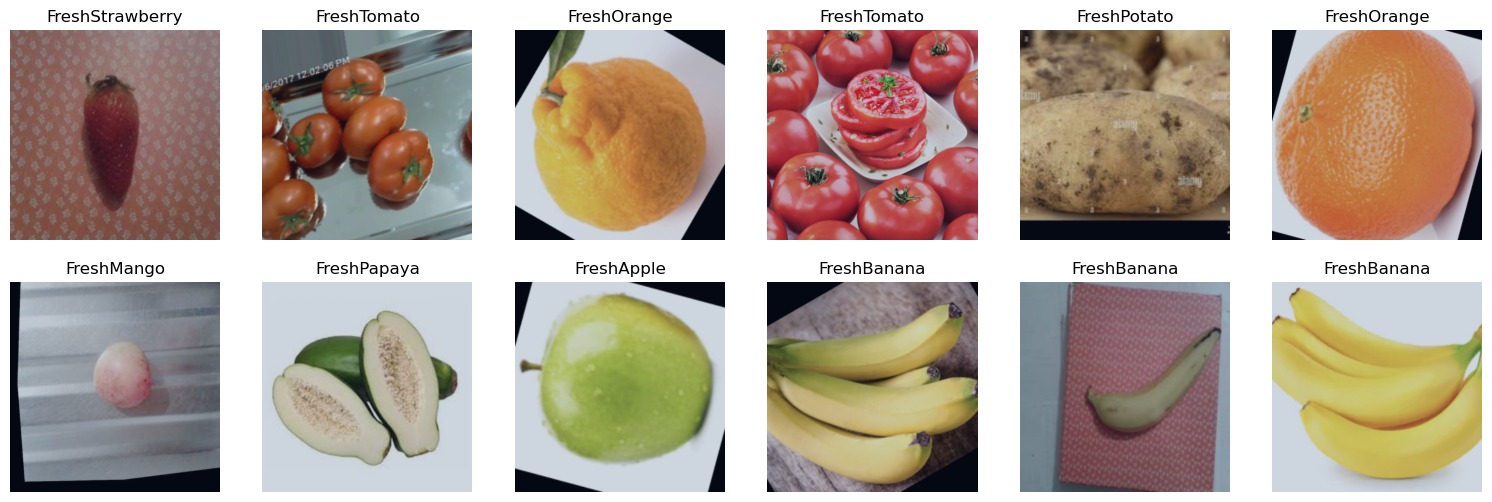

In [19]:
# visualize a batch of train data loader
images, labels = next(iter(train_dataloader))
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(19, 6))
rows, cols = 2, 6
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image_ = np.transpose(images[i], (1, 2, 0)) 
    image_ = image_*[0.18]+[0.4] # unnormalize 
    plt.imshow(image_)
    plt.title(class_names[labels[i].item()])
    plt.axis(False);

### Train model

In [20]:
class EarlyStopping:
  def __init__(self, patience=7, verbose=False, delta=0.001):

    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss):

    if self.best_score is None:
      self.best_score = val_loss
    elif (self.best_score - val_loss) < self.delta:
      self.patience -= 1
      if self.verbose and self.patience > 0:
        print(f'Loss validation not improved enough for {self.patience} epochs yet.  Waiting...')
    else:
      self.best_score = val_loss
      self.patience = self.patience  # reset patience if validation loss improves

    if self.patience <= 0:
      if self.verbose:
        print('Early stopping triggered.')
      self.early_stop = True

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel')
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
early_stopping = EarlyStopping(patience=7, verbose=True)

In [22]:
# Set the manual seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)

from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d%H%M')
model_name_saved = f'{timestamp}_{model.__class__.__name__}'
print(model_name_saved)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
print(datetime.now())

# Setup training and save the results
results = engine_classification.run_model(model=model,
                       train_dataloader=train_dataloader,
                       validation_dataloader=val_dataloader, 
                       optimizer=optimizer,
                       scheduler=scheduler,
                       early_stopping=early_stopping,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device,
                       model_name=model_name_saved)

# End the timer
end_time = timer()
print(f"[INFO] Total training time: {((end_time-start_time)/60):.3f} minutes")

202403051557_EfficientNet


  0%|          | 0/20 [00:00<?, ?it/s]

Training Step: 0it [00:00, ?it/s]

/usr/lib64/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Step: 0it [00:00, ?it/s]

Epoch: 1 | lr: 0.001 | train_loss: 0.5993 | train_acc: 0.8972 | validation_loss: 0.1741 | validation_acc: 0.9778
model saved at epoch: 1


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 2 | lr: 0.001 | train_loss: 0.1553 | train_acc: 0.9772 | validation_loss: 0.1076 | validation_acc: 0.9836
model saved at epoch: 2


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 3 | lr: 0.001 | train_loss: 0.1086 | train_acc: 0.9802 | validation_loss: 0.0767 | validation_acc: 0.9839
model saved at epoch: 3


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 4 | lr: 0.001 | train_loss: 0.0802 | train_acc: 0.9840 | validation_loss: 0.0659 | validation_acc: 0.9862
model saved at epoch: 4


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 5 | lr: 0.001 | train_loss: 0.0735 | train_acc: 0.9852 | validation_loss: 0.0605 | validation_acc: 0.9862
model saved at epoch: 5


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 6 | lr: 0.001 | train_loss: 0.0616 | train_acc: 0.9859 | validation_loss: 0.0539 | validation_acc: 0.9881
model saved at epoch: 6


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 7 | lr: 0.001 | train_loss: 0.0507 | train_acc: 0.9886 | validation_loss: 0.0544 | validation_acc: 0.9859
Loss validation not improved enough for 6 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 8 | lr: 0.001 | train_loss: 0.0499 | train_acc: 0.9883 | validation_loss: 0.0451 | validation_acc: 0.9885
model saved at epoch: 8


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 9 | lr: 0.001 | train_loss: 0.0444 | train_acc: 0.9897 | validation_loss: 0.0426 | validation_acc: 0.9889
model saved at epoch: 9


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 10 | lr: 0.001 | train_loss: 0.0462 | train_acc: 0.9865 | validation_loss: 0.0435 | validation_acc: 0.9881
Loss validation not improved enough for 5 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 11 | lr: 0.001 | train_loss: 0.0436 | train_acc: 0.9893 | validation_loss: 0.0413 | validation_acc: 0.9881
model saved at epoch: 11


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 12 | lr: 0.001 | train_loss: 0.0362 | train_acc: 0.9910 | validation_loss: 0.0385 | validation_acc: 0.9901
model saved at epoch: 12


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 13 | lr: 0.001 | train_loss: 0.0354 | train_acc: 0.9916 | validation_loss: 0.0415 | validation_acc: 0.9885
Loss validation not improved enough for 4 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 14 | lr: 0.001 | train_loss: 0.0311 | train_acc: 0.9930 | validation_loss: 0.0398 | validation_acc: 0.9897
Loss validation not improved enough for 3 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 15 | lr: 0.001 | train_loss: 0.0321 | train_acc: 0.9919 | validation_loss: 0.0413 | validation_acc: 0.9874
Loss validation not improved enough for 2 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 16 | lr: 0.0001 | train_loss: 0.0330 | train_acc: 0.9912 | validation_loss: 0.0393 | validation_acc: 0.9885
Loss validation not improved enough for 1 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 17 | lr: 0.0001 | train_loss: 0.0283 | train_acc: 0.9924 | validation_loss: 0.0361 | validation_acc: 0.9881
model saved at epoch: 17


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 18 | lr: 0.0001 | train_loss: 0.0279 | train_acc: 0.9926 | validation_loss: 0.0386 | validation_acc: 0.9893
Early stopping triggered.
early stopping at epoch: 17
[INFO] Total training time: 184.159 minutes


In [23]:
def plot_loss_curves(results):   
    loss = results["train_loss"]
    val_loss = results["validation_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["validation_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

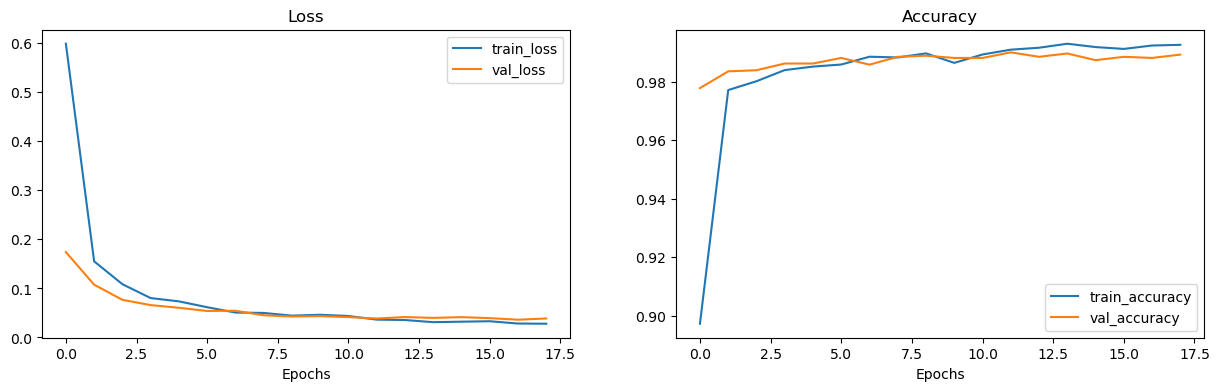

In [24]:
# Plot the loss curves of our model
plot_loss_curves(results)

In [25]:
#%load_ext tensorboard # line magic to load TensorBoard
#%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory

# Inference / Load saved model

In [26]:
import torch
import torchvision
import json
import matplotlib.pyplot as plt
import os
import random

from PIL import Image
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
# load model using full model saved
# load weights for getting transform
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
transform = weights.transforms()
model_load = torch.load(f'models/{model_name_saved}_full.pth') 
#model_load

In [35]:
# Opening file trained classes
f = open('classes_trained')
# json to dictionary
classes_names_trained = json.load(f)
# Closing file
f.close()
print(f'trained classes names: {classes_names_trained}')

trained classes names: ['FreshAlpukat', 'FreshApple', 'FreshBanana', 'FreshBellpepper', 'FreshCabbage', 'FreshCarrot', 'FreshCucumber', 'FreshDragonfruit', 'FreshMango', 'FreshOrange', 'FreshPapaya', 'FreshPotato', 'FreshSpinach', 'FreshStrawberry', 'FreshTomato']


In [39]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    classes_names_trained,
    transform,
    device):
       
    image = Image.open(image_path) # Load in image 
    
    image = transform(image).unsqueeze(0).to(device) # Transform the image, add batch dimension and put image on target device
    
    model.to(device) # model on the target device     
    model.eval() # Turn on model evaluation mode and inference mode
    
    pred_dict = {}
    
    with torch.no_grad():     
        pred_logit = model(image) # perform inference on target sample 
        pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
        pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
        #pred_class = classes_name[str(pred_label.cpu().item())] # 

        # put in the dictionary
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_label"] = pred_label

        pred_dictionary.append(pred_dict)
        
    # Plot the image
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy()*[0.18]+[0.4]) # unnormalize  
    
    if classes_names_trained:
        title = f"{classes_names_trained[pred_label.cpu().item()]} | Prob: {pred_prob.max().cpu():.4f}"
    else:
        title = f"{pred_label.cpu().item()} | Prob: {pred_prob.max().cpu():.4f}"
        
    plt.title(title)
    plt.axis(False)

    return pred_dictionary

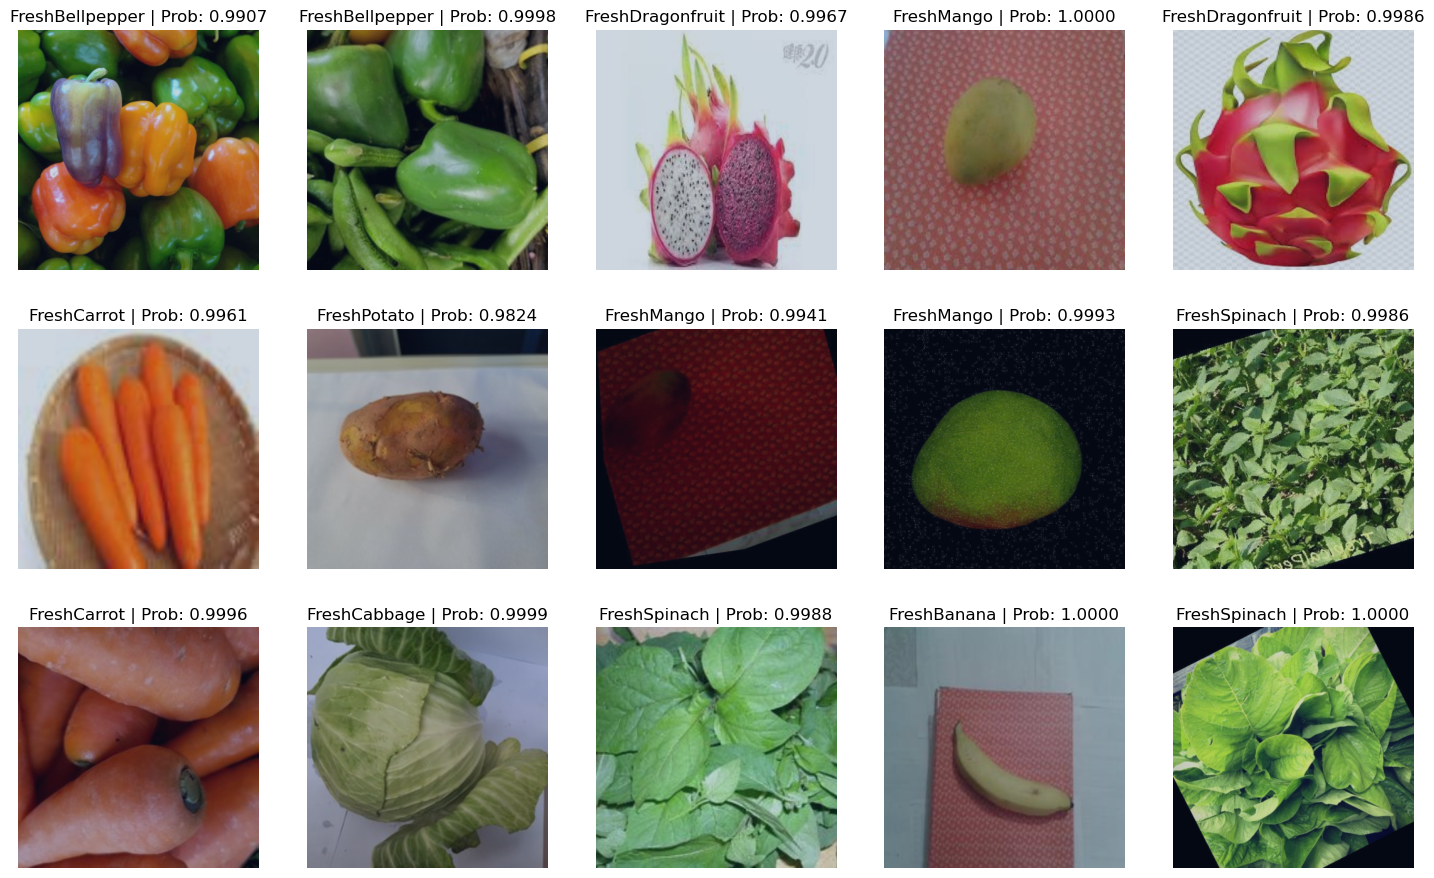

In [42]:
# Set the manual seeds
SEED2=67
torch.manual_seed(SEED2)
torch.cuda.manual_seed(SEED2)
random.seed(SEED2)

root_path = Path(os.getcwd())
# Get a list of all test image filepaths
test_dir = root_path / "dataset_subset" / "test"
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

pred_dictionary=[]

# Randomly select a test image path
img_paths = random.sample(test_data_paths, k=15)

fig = plt.figure(figsize=(18, 11))
rows, cols = 3, 5
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    img = img_paths[i]
    pred_dictionary = pred_and_plot_image(model_load, img, classes_names_trained, transform, device)